*ADS-A topics: Support Vector Machines, Face Recognition, Working with images, Cross validation libraries, Sklearn.metrics*

*Author: Gerard Schouten (2017), Merel Veracx (2018)*

# Face Recognition with Support Vector Machines

In this partly finished notebook, the Support Vector Machine algorithm is used to recognize faces. We will use the Olivetti faces dataset, as included in Scikit-Learn library. More info at: http://scikit-learn.org/stable/datasets/olivetti_faces.html

We start by importing numpy, scikit-learn, and matplotlib, the Python libraries we will be using for this analysis. 

First, we show the versions of these libraries (that is always wise to do in case you have to report problems running the notebooks!) and use the inline plotting mode statement.

In [47]:
import IPython
import sklearn as sk 
import numpy as np # linear algebra
import matplotlib 
import matplotlib.pyplot as plt # for plotting faces   
from skimage.io import imshow

%matplotlib inline


print('IPython version:', IPython.__version__)
print('numpy version:', np.__version__)
print('scikit-learn version:', sk.__version__)
print('matplotlib version:', matplotlib.__version__)

IPython version: 7.19.0
numpy version: 1.19.2
scikit-learn version: 0.23.2
matplotlib version: 3.3.2


## 1 - Load Olivetti Face Dataset

#### DIY
Write the code to import the olivetti faces dataset. Load them into the variable faces. Make sure to use the correct library from sklearn.datasets. Check if the dataset has been loaded correctly by inspecting the description.

In [48]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()

print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

## 2 - Investigate the Olivetti Face Dataset

As you can see by running the following statement, the result of fetch_olivetti_faces(), as stored in the variable `faces`, is a dictionary with the following keys: `faces.target`, `faces.images`, `DESCR`, `data`.

In [49]:
print(faces.keys())
print(faces.images.shape)
print(faces.data.shape)
print(faces.target.shape)

dict_keys(['data', 'images', 'target', 'DESCR'])
(400, 64, 64)
(400, 4096)
(400,)


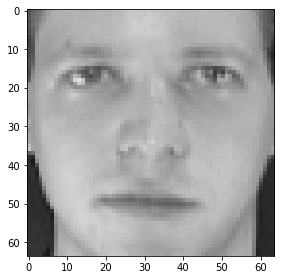

In [50]:
# See an image
firstImage = faces.images[0]
imshow(firstImage)

#### DIY What conclusions can you draw from this information? 

* How many images are present in the dataset? **400**
* What is the image size in terms of pixels? **64 x 64**
* How many persons are there? **40**

#### DIY How can we inspect that the data is already normalized? Is scaling still necesarry?

In [51]:
print(np.max(faces.data))
print(np.min(faces.data))
print(np.mean(faces.data))

1.0
0.0
0.5470426


#### DIY Plot the first 20 images in a row. 

Hint: Make a figure with 20 subplots of 20px on 20px. You can use p.fig.add_subplot and p.imshow(images[i]) to add an image and p.text to add the index of the image and the label. You can find code examples online [Ex](http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html).

In [52]:
def print_faces(images, target, top_n):
    
    # Set up the figure size in inches
    fig = plt.figure(figsize=(20, 20))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    
    for i in range(top_n):
        
        # Plot the images in a matrix of 20x20
        p = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
        p.imshow(images[i], cmap='gray')
        
        # Label the image with the target value
        p.set_title(bool(target[i]))      
        p.text(0, 60, str(i))

#### DIY Plot the first 20 images in a row. 
Change your code above into a function print_faces(faces.images, faces.target, numberOfImages).

Use this function to plot all the faces in a matrix of 20x20.

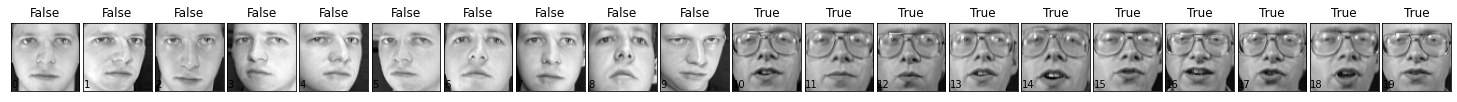

In [53]:
print_faces(faces.images, faces.target, 20)

As you can see now we have confirmed that there are 40 individuals with 10 different images each in the dataset.

##### Show 40 Distinct People in the dataset

In [54]:
def show_distinct_people(images, unique_ids):
    
    # Creating 4X10 subplots in  18x9 figure size
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(20, 10))
    
    # For easy iteration flattened 4X10 subplots matrix to 40 array
    axarr=axarr.flatten()
    
    # Iterating over user ids
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
    plt.suptitle("There are 40 distinct people in the dataset")
    

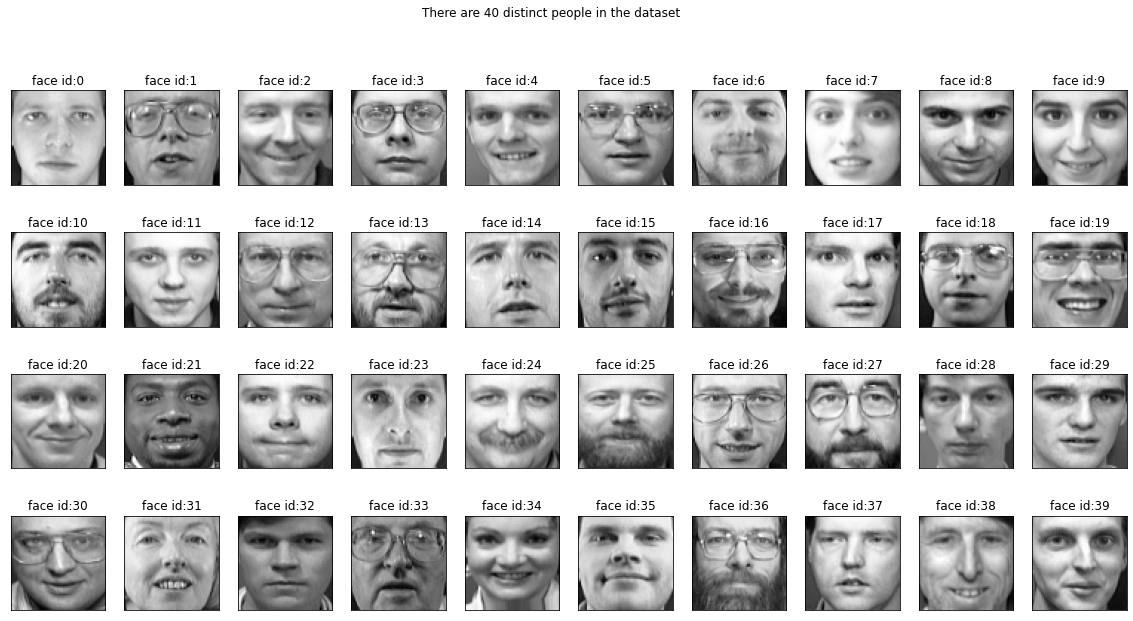

In [55]:
show_distinct_people(faces.images, np.unique(faces.target))

## 3 - Analysis with SVM

We will build a classifier whose model is a hyperplane that separates instances of one class from the rest. Support Vector Machines (SVM) are supervised learning methods that try to obtain these hyperplanes in an optimal way, by selecting the ones that pass through the widest possible gaps between instances of different classes. New instances will be classified as belonging to a certain category based on which side of the surfaces they fall on. 

#### DIY Identify the classes, features, training data and test data. 
As in the Google Car example from class, try to make a visualisation of the different items in this machine learning algorithm.

#### Guide: possible answer

* classes: the 40 individuals
* features: the grey value of 20 x 20 pixels, so there are 400 features for each datapoint
* training data: several pictures of each of the 40 individuals
* test data: minimally one picture of each of the 40 individuals

In [56]:
# Reshape images for machine learnig model
image = faces.images.reshape((faces.images.shape[0],faces.images.shape[1]*faces.images.shape[2]))
print("image shape:",image.shape)

image shape: (400, 4096)


#### DIY create a SVC linear kernel in the variable svc_1

In [57]:
from sklearn.svm import SVC

# Create SVC
# Run classifier, using a model that is too regularized (C too low) to see the impact on the results
svc_1 = SVC(kernel='linear')
print(svc_1)

SVC(kernel='linear')


#### DIY Build training and testing sets

Keep the images you think the algorithm will have the most problem with in the test set.

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, train_size=0.8, random_state=0, stratify=faces.target)

#### DIY Train your classifier and evaluate it with the test data

Use sklearn.metrics to inspect the accuracy of the test set.

In [59]:
from sklearn.metrics import accuracy_score

# Training using 'training data'
svc_1.fit(X_train, y_train) # fit the model for training data

# Predict the 'target' for 'training data'
X_pred = svc_1.predict(X_train)
self_accuracy = accuracy_score(y_train, X_pred)
print("Accuracy for training data (self accuracy):", self_accuracy)

# Predict the 'target' for 'test data'
y_pred = svc_1.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy score: {100 * test_accuracy:.2f}%")
num_correct = np.sum(y_test == y_pred)
print(f"Number of correctly classified samples: {num_correct}")
num_incorrect = len(y_test) - num_correct
print(f"Number of incorrectly classified samples: {num_incorrect}")



Accuracy for training data (self accuracy): 1.0
Accuracy score: 95.00%
Number of correctly classified samples: 76
Number of incorrectly classified samples: 4


##### DIY Apply KFold on the Facial Recognition with SVM

[[source]](https://scikit-learn.org/stable/modules/cross_validation.html)

In [60]:
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem

def evaluate_kfold_cross_validation(clf, X, y, K):
    
    # Create a k-fold croos validation iterator
    kf = KFold(n_splits=K, shuffle=False, random_state=0)
    
    # By default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=kf)
    
    print(scores)
    print (f"Mean score: {round(np.mean(scores), 3)} (+/-{round(sem(scores), 3)})")

#### DIY Inspect the wrong classifications

* How does the classifier perform on your perceived hard images? 
* What is the image that is misclassified? Why?


In [61]:
from sklearn import metrics

cm = metrics.confusion_matrix(y_test,y_pred)

# Show confusion matrix
cm

array([[2, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 0, 2]], dtype=int64)

Text(87.0, 0.5, 'Truth')

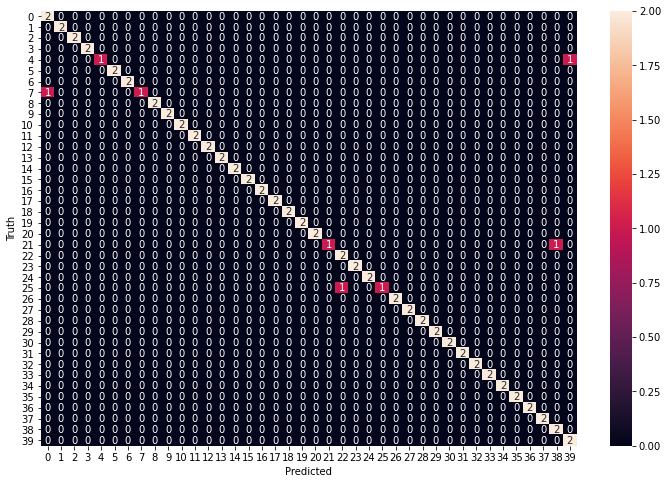

In [62]:
import seaborn as sn

plt.figure(figsize = (12,8))
sn.heatmap(cm, annot=True)

plt.xlabel('Predicted')
plt.ylabel('Truth')

From the confusion matrix we can see that 4, 7, 21, 25 are misclassifeid. Let's see why

In [63]:
def misclassified_people(images, unique_ids):
    
    fig, axarr=plt.subplots(nrows=len(unique_ids), ncols=10, figsize=(20, 20))
    
    # Iterating over user ids
    image_index = 0
    for unique_id in unique_ids:
        for num in range(0,10):
            index = unique_id*10 + num
            axarr[image_index,num].imshow(images[index], cmap='gray')
            axarr[image_index,num].set_xticks([])
            axarr[image_index,num].set_yticks([])
            axarr[image_index,num].set_title("face id:{}".format(unique_id))
        image_index = image_index + 1

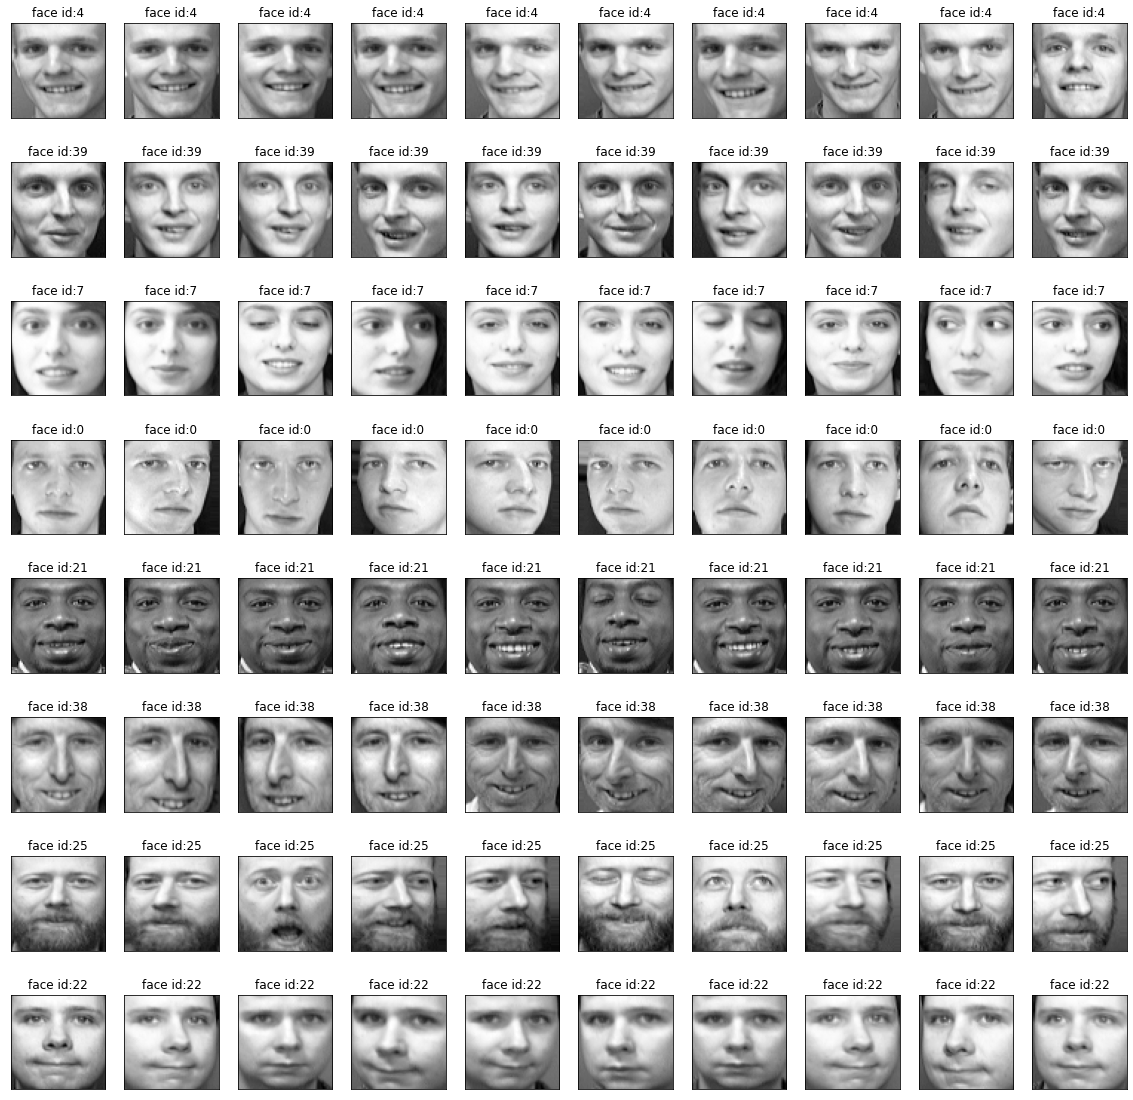

In [64]:
# Show misclassified people
misclassified_images = [4, 39, 7, 0, 21, 38, 25, 22]

misclassified_people(faces.images, misclassified_images)

All the pictures are just simillar to each other. For instance the person with id 21 is smilling as well as the person with id 38; the face expression of the person with id 25 is really close to this of 22; So, as well all the missclassified images of the model.  

### Cross-validation

As learned in class, when training the model and tuning its hyperparameters, overfitting on the training data is possible.

#### DIY Perform 5-fold cross-validation. 
Show what all the accuracy scores are and compute the average value.

In [65]:
# Ignore packages warnings
import warnings
warnings.filterwarnings("ignore")

In [66]:
# Evaluate 
evaluate_kfold_cross_validation(svc_1, X_train, y_train, 5)

[0.890625 0.921875 0.921875 0.875    0.953125]
Mean score: 0.912 (+/-0.014)


#### DIY Write down your conclusion of the K-fold cross validation.

The K-fold cross-validation analysis means that it is doing K random sampling of the data.
First, pick a percentage of training/testing split. let's say 95% then during the first fold : takes randomly 95% of patient in a data set, trains the model into this. Then tests the model into the other 5% (testing set). Second fold, take another random 95% and do the same. We can see the accuracy results after each fold.

Observing cross-validation folds I saw that the first and the four one are not doing well at training the model because they are less accurate compared to the others.

Can you find which images where wrongly misclassified in the worst run?

In [67]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       1.00    

Thats pretty good , we can identify the wrong predictions from this report and inspect the images independently to see why they were misclassified. We can visualize a confusion matrix to confirm this.

In [68]:
def print_misclassified_faces(images, targets):
    
    # Set up the figure size in inches
    fig = plt.figure(figsize=(20, 20))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    
    for i, val in enumerate(targets):
        
        # Plot the images in a matrix of 20x20
        p = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
        p.imshow(images[i], cmap='gray')
        
        # Label the image with the target value
        p.set_title(val)

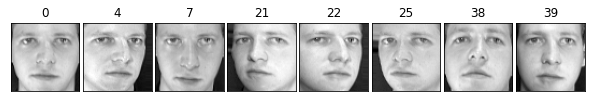

In [69]:
misclassified_images = [0, 4, 7, 21, 22, 25, 38, 39]

print_misclassified_faces(faces.images, misclassified_images)

### StratifiedKFold

The function ``StratifiedKFold`` is a variation of k-fold which returns stratified folds: Each set contains approximately the same percentage of samples of each target class as the complete set.

The example below illustates this. There are 2 classes, and the StratifiedKFold creates 3 train and test sets, each containing the indexes of the elements selected.

In [70]:
from sklearn.model_selection import StratifiedKFold

labels = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
skf = StratifiedKFold(3)

for train, test in skf.split(labels, labels):
     print("%s %s" % (train, test))

[2 3 6 7 8 9] [0 1 4 5]
[0 1 3 4 5 8 9] [2 6 7]
[0 1 2 4 5 6 7] [3 8 9]


#### DIY Apply StratifiedKFold on the Facial Recognition with SVM
[[source]](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

In [71]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy.stats import sem

def evaluate_stratifiedkfold_cross_validation(clf, X, y, K):
    
    # Create a k-fold croos validation iterator
    skf = StratifiedKFold(K)
    skf.get_n_splits(X, y)
    
    for train_index, test_index in skf.split(X, y):
        print("%s %s" % (train, test))
    
    # By default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=skf)
    
    print(scores)
    print (f"Mean score: {round(np.mean(scores), 3)} (+/-{round(sem(scores), 3)})")


In [72]:
# Evaluate 
evaluate_stratifiedkfold_cross_validation(svc_1, X_train, y_train, 5)

[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0.953125 0.984375 1.       0.953125 1.      ]
Mean score: 0.978 (+/-0.011)


### LeaveOneOut
The function ``LeaveOneOut`` (or LOO) is a simple cross-validation. Each learning set is created by taking all the samples except one, the test set being the sample left out. Thus, for n samples, we have n different training sets and n different tests set. This cross-validation procedure does not waste much data as only one sample is removed from the training set.

The code example below illustrates this:

from sklearn.cross_validation import LeaveOneOut

loo = LeaveOneOut(4)
for train, test in loo:
    print("%s %s" % (train, test))

Potential users of LOO for model selection should weigh a few known caveats. When compared with k-fold cross validation, one builds n models from n samples instead of k models. Moreover, LOO is trained on n-1 samples rather than (k-1)/k * n. Hence LOO is computationally more expensive than k-fold cross validation.


In terms of accuracy, LOO often results in high variance as an estimator for the test error. Intuitively, since n-1 of the n samples are used to build each model, models constructed from folds are virtually identical to each other and to the model built from the entire training set.
However, if the learning curve is steep for the training size in question, then 5- or 10- fold cross validation can overestimate the generalization error.

As a general rule, most authors, and empirical evidence, suggest that 5- or 10- fold cross validation should be preferred to LOO.

#### DIY Apply LeaveOneOut on the Facial Recognition with SVM
[[source]](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html)

In [73]:
from sklearn.model_selection import cross_val_score, LeaveOneOut
from scipy.stats import sem

def evaluate_leaveoneout_cross_validation(clf, X, y):
    
    # Create a k-fold croos validation iterator
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    
    for train_index, test_index in loo.split(X):
        print("%s %s" % (train, test))
    
    # By default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=skf)
    
    print(scores)
    print (f"Mean score: {round(np.mean(scores), 3)} (+/-{round(sem(scores), 3)})")


In [74]:
# Evaluate 
evaluate_leaveoneout_cross_validation(svc_1, X_train, y_train)

[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] [3 8 9]
[0 1 2 4 5 6 7] 

## 4 - Optionally: Other Metrics

We import the sklearn ``metrics`` package and determine also precision and recall for the test set, for _each class_. 

#### DIY The code is given ... can you figure out what happens?

In [75]:
from sklearn import metrics

def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    
    clf.fit(X_train, y_train)
    
    print("Accuracy on training set:")
    print(clf.score(X_train, y_train))
    print("Accuracy on testing set:")
    print(clf.score(X_test, y_test))
    
    y_pred = clf.predict(X_test)
    
    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(metrics.confusion_matrix(y_test, y_pred))

In [76]:
train_and_evaluate(svc_1, X_train, X_test, y_train, y_test)

Accuracy on training set:
1.0
Accuracy on testing set:
0.95
Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         

#### DIY What is your overall conclusion? Can you explain the confusion matrix?

In [77]:
## Your answer

#Conclusion: Performance of SVM for face recognition is incredibly high!
#Confusidiy  matrix: Excellent tool to find problemetic data (which face goes wrong).


## 5 - Discriminate People with or without Glasses

Now, another problem. 

Try to classify images of people with and without glasses. A few tips to take into account.
- Use the indexes below to relabel all the images
- Create a training & test set for this new problem
- Again try a [linear SVC classifier](http://en.wikipedia.org/wiki/Kernel_%28linear_algebra%29) (start by using the default parameters)
- Do the analysis and evaluate.
- And  show a classification report as above.
- Which images go wrong?

In [78]:
# Index ranges of images of people with glasses
glasses = [
	(10, 19), (30, 32), (37, 38), (50, 59), (63, 64),
	(69, 69), (120, 121), (124, 129), (130, 139), (160, 161),
	(164, 169), (180, 182), (185, 185), (189, 189), (190, 192),
	(194, 194), (196, 199), (260, 269), (270, 279), (300, 309),
	(330, 339), (358, 359), (360, 369)
]

#### DIY Create a new target based on the indexes above.

Use that target to create a train and test set.

In [79]:
def create_target(segments):
    
    # Create a new y array of target size initialized with zeros
    y = np.zeros(faces.target.shape[0])
    
    # Put 1 in the specified segments
    for (start, end) in segments:
        y[start:end + 1] = 1
        
    return y


target_glasses = create_target(glasses)

#### DIY Train your SVM and validate

Which test pictures are misclassified?

In [80]:
X_train, X_test, y_train, y_test = train_test_split(faces.data, target_glasses, test_size=0.25, random_state=0)

In [81]:
# Create SVC
svc_2 = SVC(kernel='linear')

In [82]:
# Evaluate 
evaluate_kfold_cross_validation(svc_2, X_train, y_train, 5)

[1.         1.         0.96666667 0.9        0.96666667]
Mean score: 0.967 (+/-0.018)


In [83]:
train_and_evaluate(svc_2, X_train, X_test, y_train, y_test)

Accuracy on training set:
1.0
Accuracy on testing set:
0.99
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99        67
         1.0       0.97      1.00      0.99        33

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion Matrix:
[[66  1]
 [ 0 33]]


In [84]:
## Your answers ...

### DIY Learn glassed from one individual, test with all data

Now, let's train with only 10 images: all from the same person, sometimes with glasses and sometimes without glasses. With this we'll try to discard that it's remembering faces, instead of features related with glasses. We'll separate the subject with indexes from 30 to 39. We'll train and evaluate in the rest of the 390 instances. After that, we'll evaluate again over the separated 10 instances.

[[numpy ones]](https://numpy.org/doc/stable/reference/generated/numpy.ones.html)


In [85]:
X_test = faces.data[30:40]
y_test = target_glasses[30:40]

print(y_test.shape[0])

select = np.ones(target_glasses.shape[0])
select[30:40] = 0
X_train = faces.data[select == 1]
y_train = target_glasses[select == 1]

print(y_train.shape[0])

10
390


In [86]:
# Create SVM
svc_3 = SVC(kernel='linear')

train_and_evaluate(svc_3, X_train, X_test, y_train, y_test)

# Predict
y_pred = svc_3.predict(X_test)

Accuracy on training set:
1.0
Accuracy on testing set:
0.9
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91         5
         1.0       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10

Confusion Matrix:
[[5 0]
 [1 4]]


#### Show the evaluation faces, and their predicted category.

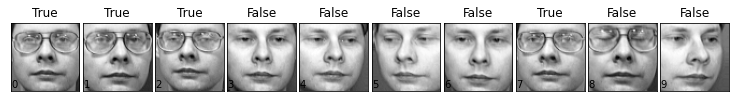

In [87]:
eval_faces = [np.reshape(a, (64, 64)) for a in X_test]

print_faces(eval_faces, y_pred, 10)

Face number eight is incorrectly classified as no-glasses (probably because his eyes are closed!).